In [16]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv(r'C:\Users\ozarr\fall2022\project3\mirror\08_gap-every-five-years.tsv', sep='\t')

#using plotly express

fig = px.scatter(df, x="year", y="lifeExp", trendline="ols")
fig.data[1].line.color = 'red'
fig.update_layout(title_text='Life Expectancy for each countries over each Year', title_x=0.5)
fig.show()

df['avg_lifeExp'] = df.groupby('year')['lifeExp'].transform('mean')

fig = px.scatter(df, x="year", y="avg_lifeExp", trendline="ols")
fig.data[1].line.color = 'red'
fig.update_layout(title_text='Average life expectancy for all countries over each Year', title_x=0.5)
fig.show()






There is a general increasing trend for life expectancy across time. The trend seems to be linear. Hovering over the red line in the plot shows a linear equation of Average Life Expectancy = (0.325 * year) -585.6

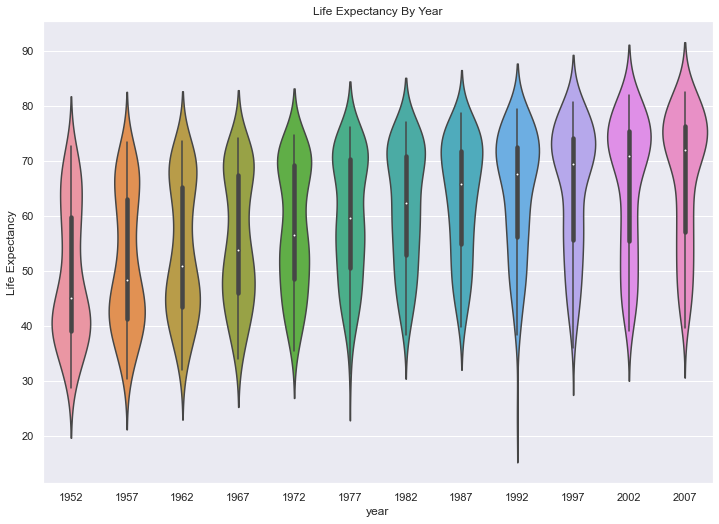

In [17]:
#using seaborn to create a violin plot

sns.set(rc={'figure.figsize':(12,8.5)})
ax = sns.violinplot(x=df.year, y=df.lifeExp, data=df)
ax.set_title("Life Expectancy By Year")
ax.set_ylabel("Life Expectancy")
ax.set_xlabel("year")

plt.show()

The data seems to be left skewed because the tails of the violin plots are longer than the heads (aka negative skewness). This means that there are countries with noticabely low life expectancies compared to the rest of the countries. The data is not unimodal as there is no noticable peak, and the median and peak of the violin plots continues to increase every year. The violin plot does not seem to symmetrical. The thick section indicates a higher probability of the Life Expectancy falling within that range, so that means that a random country is more likely to have a hiigher life expectancy than not, and that a select few countries are weighing the average life expectancy down.

If a linear regression model was fit for year vs life expectancy I think the null hypothesis would be rejected, because there is a noticable relashionship between year and life expectancy according to the graph, and also intuitively.

I suspect that the violin plot of the residuals will look similar to the violin plot of the data itself, except the plots would look symmetrical and not be on a positive upward trend since the life expectancies aren't inceasing and we are only looking at residual data from each year.

Looking at the assumptions of the linear regression model, the violin plot should all look the same. One condition is Homoscedasticity, which means the variance of residual is the same for any given year. The second condition is normality, which means that for any given year, the distribution of the life expectancy is normally distributed. The others are linearity and independence, which means that the year and life expectancy have a linear relashionship and that each obersvation of life expectancies are independent from one another. Since all of these conditions are met, everything is ok.

0.1865775891825211
For every year, the life expectancy increases by [[0.32467473]] years on average.


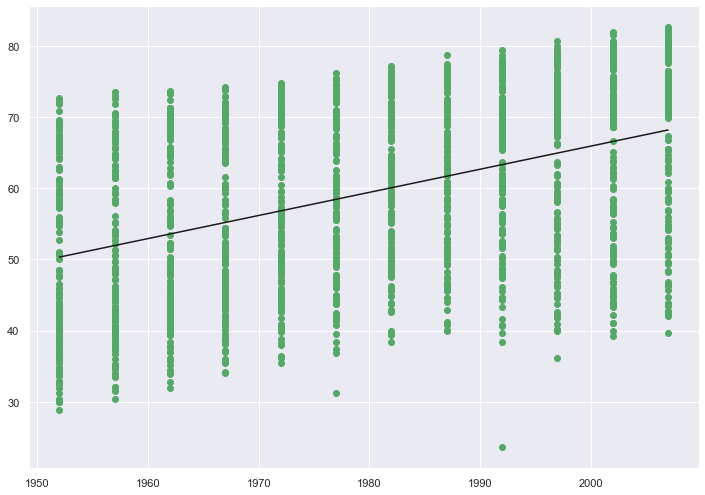

In [18]:
from sklearn import preprocessing, svm, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

df.isnull().values.any() # no null entries so we don't need to clean

#linear regression model
X = np.array(df['year']).reshape(-1, 1)
y = np.array(df['lifeExp']).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)
regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

plt.scatter(X, y,color='g')
plt.plot(X, regr.predict(X),color='k')

coeff = regr.coef_
print("For every year, the life expectancy increases by {} years on average.".format(coeff))

In [19]:
#finding the p-value using statsmodels

import statsmodels.api as sma
from scipy import stats

X2  = sma.add_constant(X)
step1  = sma.OLS(y, X2)
step2  = step1.fit()
print(step2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     398.6
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           7.55e-80
Time:                        18:29:17   Log-Likelihood:                -6597.9
No. Observations:                1704   AIC:                         1.320e+04
Df Residuals:                    1702   BIC:                         1.321e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -585.6522     32.314    -18.124      0.0

We can reject the null hypothesis because the p value is 0, which is less than 0.05. In other words, a low p value means that changes in the predictor variable (year) are highly related to changes in the response variable (life expectancy).

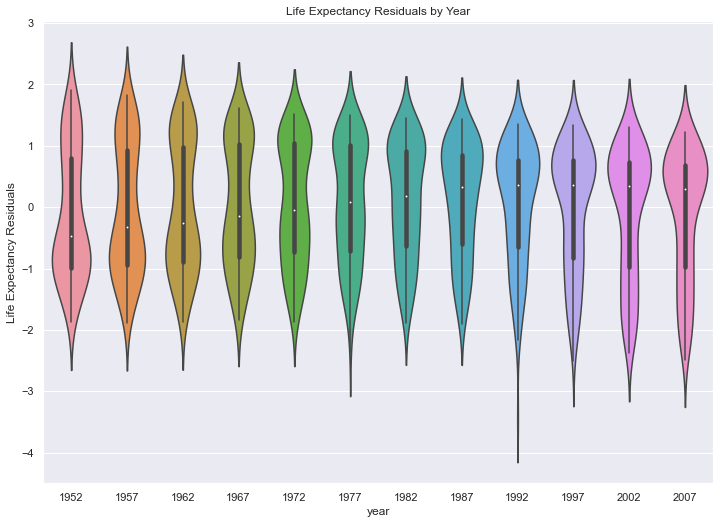

In [20]:
#Residual Violin Plot
influence = step2.get_influence()
standardized_residuals = influence.resid_studentized_internal

sns.set(rc={'figure.figsize':(12,8.5)})
ax = sns.violinplot(x=df.year, y=standardized_residuals, data=df)
ax.set_title("Life Expectancy Residuals by Year")
ax.set_ylabel("Life Expectancy Residuals")
ax.set_xlabel("year")

plt.show()

The plot of residuals doesn't match my initial expectations that I previously stated because the violin plots differ from each quite a bit. However, I was correct when I said that the residual plot would not be on a "visual" upwards trend. The mean of the residuals have actually increased per year whoch means the average prediction of the points gradually became "over-estimates" The maximum residual per year also decreases across time which means the prediction get closer to the observed value throughout time.

In [21]:
fig = px.box(df, x="continent", y=standardized_residuals, title = "Box Plot of Residuals by Continent")
fig.update_yaxes(title="Life Expectancy Residuals")
fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

There does seem to be a dependency for the model residuals and the different continents. For example, the distribution is much smaller for continents like Oceania and there are more outliers for continents like Europe. Because of this, I would suggest performing a linear regression analysis of life expectancy for each continent separately instead of all the data all at once.

Text(0.5, 1.0, 'Linear Regression by Continent')

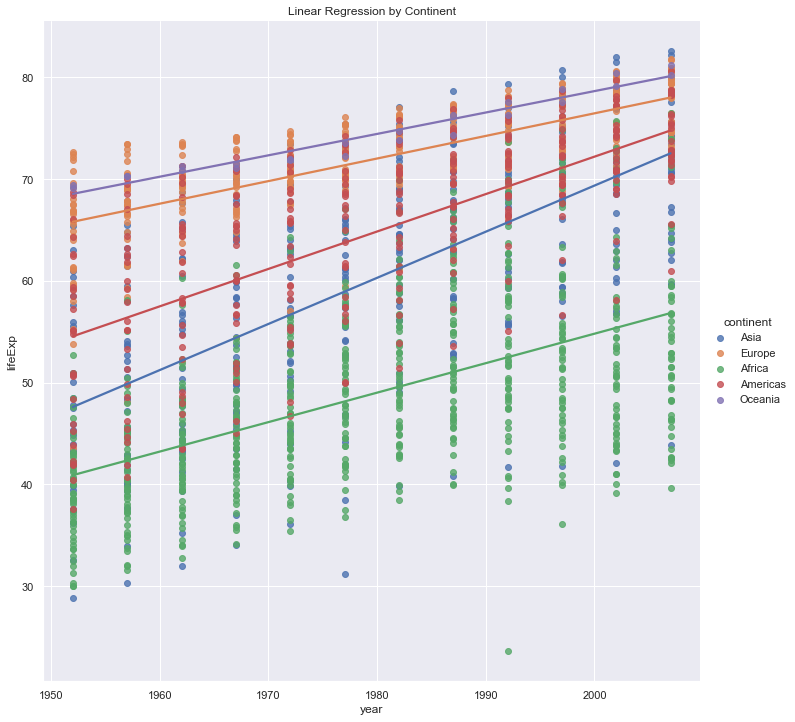

In [22]:
sns.lmplot(x="year", 
           y="lifeExp", 
           hue="continent",
           ci=None,
           data=df,
           height=10)
plt.title("Linear Regression by Continent")

Based on the plot, the model should include an interaction term for continent because the slopes for some of the continents differ which suggests an interaction effect.

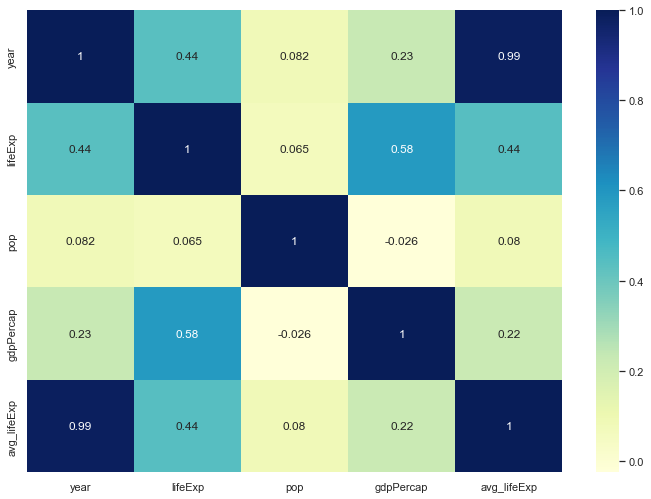

In [23]:
#quick correlation exploration
correlation = df.corr()
sns.heatmap(correlation,cmap="YlGnBu",annot=True)
plt.show()

In [24]:
#Linear Regression Model with an Interaction Term between year and continent
import statsmodels.formula.api as smf
model_interaction = smf.ols(formula='lifeExp ~ continent + year:continent', data=df)
model = model_interaction.fit()
summary = model.summary()
print(summary.tables[1])

                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 -524.2578     32.963    -15.904      0.000    -588.911    -459.605
continent[T.Americas]     -138.8484     57.851     -2.400      0.016    -252.315     -25.382
continent[T.Asia]         -312.6330     52.904     -5.909      0.000    -416.396    -208.870
continent[T.Europe]        156.8469     54.498      2.878      0.004      49.957     263.737
continent[T.Oceania]       182.3499    171.283      1.065      0.287    -153.599     518.298
year:continent[Africa]       0.2895      0.017     17.387      0.000       0.257       0.322
year:continent[Americas]     0.3677      0.024     15.309      0.000       0.321       0.415
year:continent[Asia]         0.4531      0.021     21.678      0.000       0.412       0.494
year:continent[Europe]       0.2219      0.022     10.123      0.000  

The only paramater that has a p value significantly different from 0 is the paramter of the continent of oceania and the interaction between year and the coninent of Oceania. This indicates that using the interaction between year and the continent of Oceania is not statistically significant.

In [25]:
# Printing Out Slopes of the interaction between continent and year
print(model.params[5:])

year:continent[Africa]      0.289529
year:continent[Americas]    0.367651
year:continent[Asia]        0.453122
year:continent[Europe]      0.221932
year:continent[Oceania]     0.210272
dtype: float64


For every year the life expectacy increases approximately 0.29 years for Africa, 0.37 years for the Americas, 0.45 years for Asia, 0.22 years for Europe, and 0.21 years for Oceania.

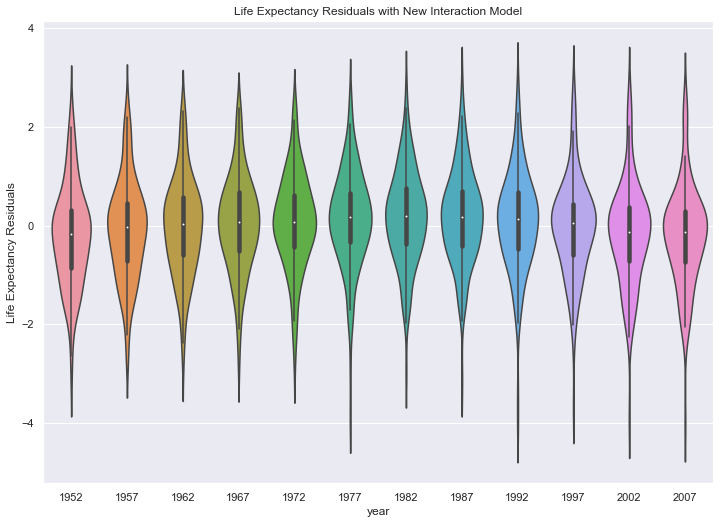

In [26]:
#Residual Violin Plot using the new model with an interaction term
influence = model.get_influence()
standardized_residuals = influence.resid_studentized_internal

sns.set(rc={'figure.figsize':(12,8.5)})
ax = sns.violinplot(x=df.year, y=standardized_residuals, data=df)
ax.set_title("Life Expectancy Residuals with New Interaction Model")
ax.set_ylabel("Life Expectancy Residuals")
ax.set_xlabel("year")

plt.show()

The linear regression model assumes that the variance of the residual is the same for any value of x. This model has approximately the same variance for all values of x, but not exactly. This means that the model equation could use some fine-tuning, but it is fairly accurate.

# Classification - Random Forest

In [27]:
#using dataset of mushrooms to predict whether they are edible or not
#variable explanation can be found at https://www.kaggle.com/datasets/uciml/mushroom-classification

#using random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

shroom_df = pd.read_csv(r'C:\Users\ozarr\mushrooms.csv')
shroom_df.isnull().sum()
shroom_df['class'] = shroom_df['class'].replace({'p': 'poisonous', 'e': 'edible'})
shroom_df.rename(columns = {'class':'target'}, inplace = True)

#one-hot encoding
df_dummies = pd.get_dummies(data=shroom_df, columns=shroom_df.columns[1:])
y = df_dummies['target']
X = df_dummies.drop(['target'], axis = 1)

#training model
SEED = 99
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
rfc = RandomForestClassifier(n_estimators=5, max_depth=3,random_state=SEED)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

#evaluation metrics
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

#10-fold cross validation
from sklearn.model_selection import cross_val_score, KFold
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(rfc, X, y,cv=cv, n_jobs=-1)
print(scores)

              precision    recall  f1-score   support

      edible       0.92      0.96      0.94       813
   poisonous       0.96      0.92      0.94       812

    accuracy                           0.94      1625
   macro avg       0.94      0.94      0.94      1625
weighted avg       0.94      0.94      0.94      1625

[0.92250923 0.94710947 0.93111931 0.91758918 0.92487685 0.91871921
 0.94211823 0.93842365 0.91133005 0.92857143]


# Classification - Support Vector Machine

In [28]:
#Using Support Vector Machine
from sklearn import svm

#training model
clf = svm.SVC(kernel='rbf') # radial Kernel
clf.fit(X_train, y_train)
y_pred2 = clf.predict(X_test)

#evaluation metrics
print(classification_report(y_test,y_pred2))

#10-fold cross validation
scores2 = cross_val_score(clf, X, y,cv=cv, n_jobs=-1)
print(scores2)



              precision    recall  f1-score   support

      edible       1.00      1.00      1.00       813
   poisonous       1.00      1.00      1.00       812

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Writeup

The dataset that I chose has binary predictors of whether a mushroom is edible or is poisonous. The target varaible is if the mushroom is poisonous or edible and the predictors are on features of the mushroom (ex: size, environment, shape, and more). The two classification algorithms I used is a random forest and support vecotr machine (SVM). For the random forest, I decided to set the max number of trees to 5 and the depth to 3. I decided to use these paramaters to make the speed of the model fast, and to make sure the model is not over-fit. The accuracy gets near 1.00 if I make the number of trees and depth higher, but decided to keep the hyperparameters small. 

The results of the 10-fold cross validation of the random forest resulted in similar accuracy scores for all iterations (91-94%). The SVM has perfect precision, recall, and f1 scores. This is most likely due to the fact that a culmination of some of the parameters make the target varaible linearly separable and easily distinguishable.